In [ ]:
!pip install python-Levenshtein
!pip install uszipcode
!pip install IMDbPY

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import nltk
import holidays
import datetime
from uszipcode import SearchEngine
import sqlalchemy
from imdb import IMDb
from collections import Counter
from itertools import combinations
import concurrent.futures
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from gensim.utils import simple_preprocess
from sklearn.neural_network import MLPRegressor
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE

In [ ]:
file_path = "train_features.csv"
df_eda = pd.read_csv(file_path, encoding='latin1')

In [ ]:
def detect_nulls(df):
  nan_count = df.isnull().sum()
  nan_count_gt_zero = nan_count[nan_count > 0]
  if not nan_count_gt_zero.empty:
      print("NaN Count in Columns with Count > 0:")
      print(nan_count_gt_zero)
      for column in nan_count_gt_zero.index:
            null_rows = df[df[column].isnull()].index.tolist()
            print(f"Null values detected in column '{column}' at row(s): {null_rows}")

  else:
      print("No NaN values found in any column.")

detect_nulls(df_eda)
print(df_eda.shape)

# removing null values
df_eda_cleaned = df_eda.dropna()
detect_nulls(df_eda_cleaned)
print(df_eda_cleaned.shape)


NaN Count in Columns with Count > 0:
release_date     8
IMDb_URL        10
dtype: int64
Null values detected in column 'release_date' at row(s): [79415, 79416, 79417, 79418, 79419, 79420, 79421, 79422]
Null values detected in column 'IMDb_URL' at row(s): [77294, 77711, 79415, 79416, 79417, 79418, 79419, 79420, 79421, 79422]
(79963, 35)
No NaN values found in any column.
(79953, 35)


In [ ]:
# Check for duplicate rows based on user_id and movie_id
duplicates_by_user_movie = df_eda_cleaned[df_eda_cleaned.duplicated(subset=['user_id', 'movie_id'], keep=False)]

# Display the duplicate rows if any
if not duplicates_by_user_movie.empty:
    print("Duplicate Rows based on user_id and movie_id:")
    print(duplicates_by_user_movie)
else:
    print("No duplicate rows found based on user_id and movie_id.")


No duplicate rows found based on user_id and movie_id.


## **EDA**




1. Genre distribution by gender (normalized)

Total Male Users: 59353
Total Female Users: 20610


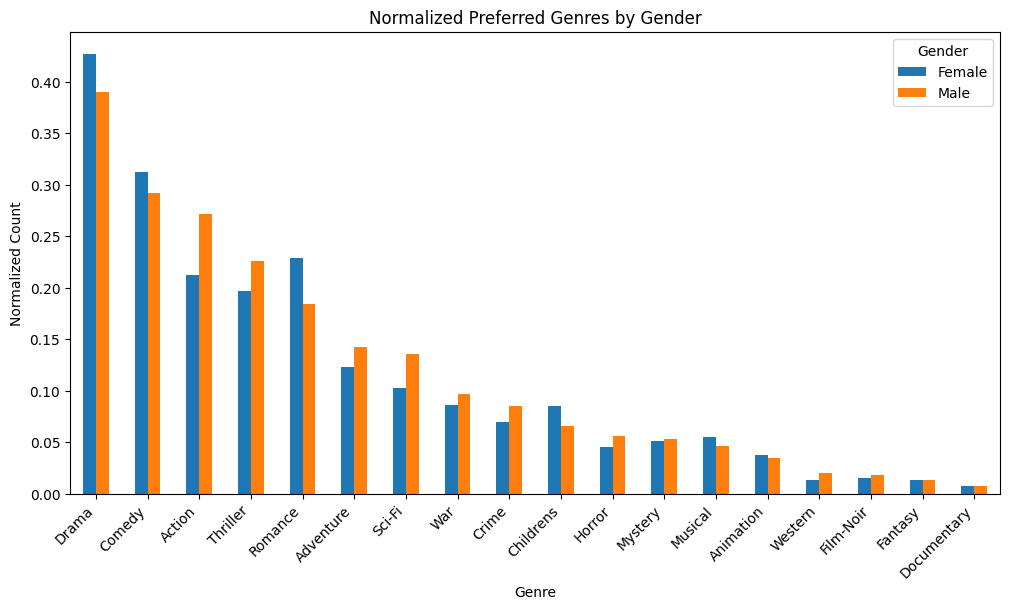

In [ ]:
# proportion of male/female users
gender_counts = df_eda['gender'].value_counts()

print("Total Male Users:", gender_counts['M'])
print("Total Female Users:", gender_counts['F'])

# genres
genres = ['Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime',
          'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
          'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

# total count of each genre by gender sorted in desc order
genre_counts = df_eda.groupby('gender')[genres].sum().transpose()
genre_counts_sorted = genre_counts.sort_values(by='M', ascending=False)

# normalize genre counts by total male and female users
genre_counts_normalized = genre_counts_sorted.copy()
genre_counts_normalized['M'] /= gender_counts['M']
genre_counts_normalized['F'] /= gender_counts['F']

# plot normalized genre counts
plt.figure(figsize=(12, 6))
genre_counts_normalized.plot(kind='bar', ax=plt.gca())
plt.title('Normalized Preferred Genres by Gender')
plt.xlabel('Genre')
plt.ylabel('Normalized Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Gender', labels=['Female', 'Male'])
plt.show()



2. Movies popularity by city

In [ ]:
def get_location_info_uszipcode(zip_code, search_engine):
    # use regex to check if the zip_code format is valid (contains only digits)
    if not re.match(r'^\d+$', zip_code):
        return {"state": "unknown", "city": "unknown"}
    result = search_engine.by_zipcode(zip_code)

    if result:
        return {
            "state": result.state,
            "city": result.major_city,
        }
    else:
        return {"state": "unknown", "city": "unknown"}

# ensure 'zip_code' is string type
df_eda['zip_code'] = df_eda['zip_code'].astype(str)

# create a SearchEngine instance
search_engine = SearchEngine()

# suppress the SQLite warning
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=sqlalchemy.exc.SAWarning)
    location_info = df_eda['zip_code'].map(lambda x: get_location_info_uszipcode(x, search_engine)).apply(pd.Series)


search_engine.close()

# combine the results with the original DataFrame
df_eda = pd.concat([df_eda, location_info], axis=1)

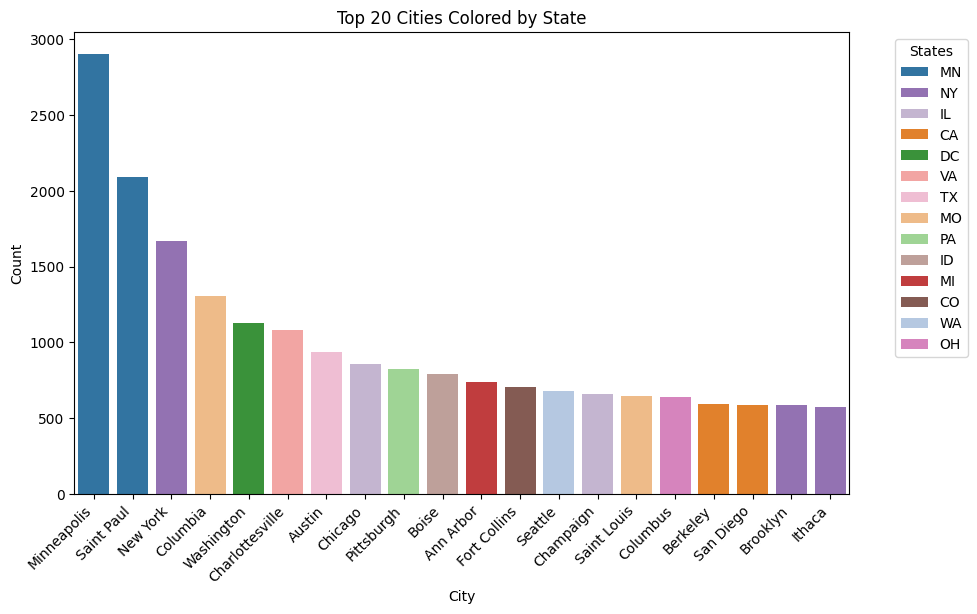

     state  counts
0       CA   10983
1       MN    6030
2       NY    5436
3       IL    4544
4       TX    4005
5  unknown    3409
6       OH    2780
7       PA    2678
8       MD    2176
9       MA    2083


In [ ]:
df_eda_by_city = df_eda[(df_eda['state'] != 'unknown') & (df_eda['city'] != 'unknown')]
top_cities = df_eda_by_city['city'].value_counts().head(20).index

df_top_cities = df_eda_by_city[df_eda_by_city['city'].isin(top_cities)]
city_to_state = df_eda_by_city.set_index('city')['state'].to_dict()

# countplot with bars colored by state using a high-contrast color palette
plt.figure(figsize=(10, 6))
sns.countplot(x='city', data=df_top_cities, order=df_top_cities['city'].value_counts().index,
             hue=df_top_cities['city'].map(city_to_state), palette='tab20', dodge=False)
plt.title('Top 20 Cities Colored by State')
plt.xlabel('City')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

# custom legend with states sorted by count
handles, labels = plt.gca().get_legend_handles_labels()
state_counts = df_top_cities['state'].value_counts()
ordered_states = state_counts.index

# filter out states not present in the legend labels
filtered_states = [state for state in ordered_states if state in labels]
ordered_handles = [handles[labels.index(state)] for state in filtered_states]
ordered_labels = filtered_states
plt.legend(ordered_handles, ordered_labels, title='States', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


# counts per state and city
counts_by_location = df_eda.groupby(['state']).size().reset_index(name='counts')
counts_by_location = counts_by_location.sort_values(by='counts', ascending=False)
print(counts_by_location.head(10).reset_index(drop=True))


3. Age distribution

Minimum Age: 7
Maximum Age: 73


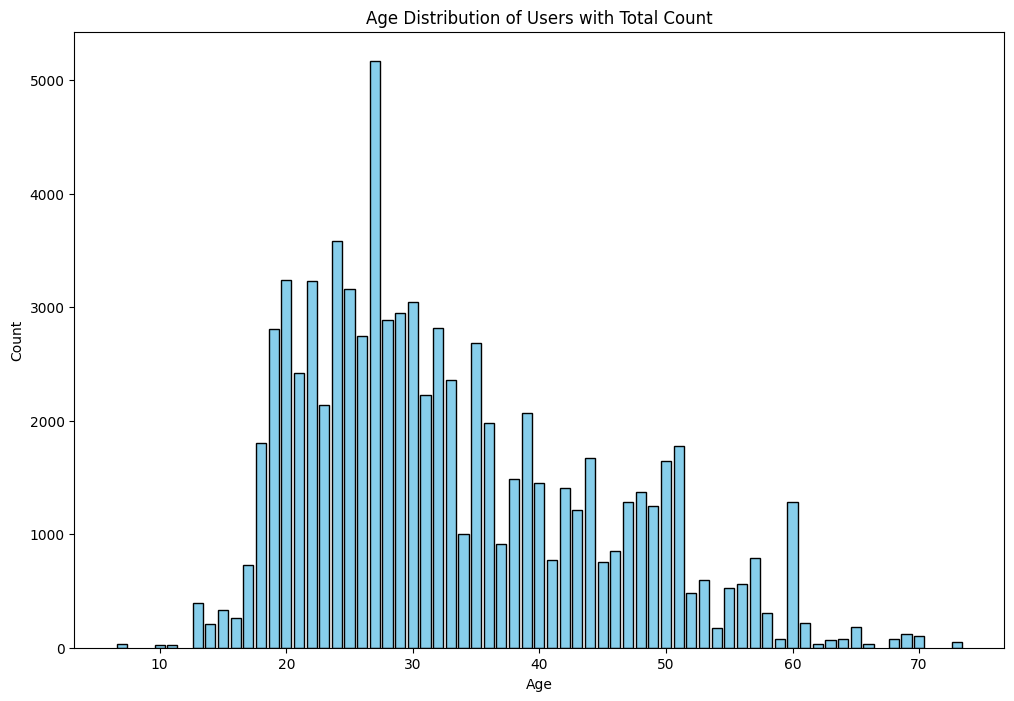

In [ ]:
# find the minimum and maximum ages
min_age = df_eda['age'].min()
max_age = df_eda['age'].max()

print(f"Minimum Age: {min_age}")
print(f"Maximum Age: {max_age}")

# plotting the age distribution with total count for each age
plt.figure(figsize=(12, 8))
age_counts = df_eda['age'].value_counts().sort_index()
plt.bar(age_counts.index, age_counts.values, color='skyblue', edgecolor='black')
plt.title('Age Distribution of Users with Total Count')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

Results ...

4. Preferred genre by age groups

age_group
0-9         34
10-12       45
13-17     1925
18-24    19222
25-34    28363
35-44    15664
45-54    10191
55-64     3945
65+        574
dtype: int64


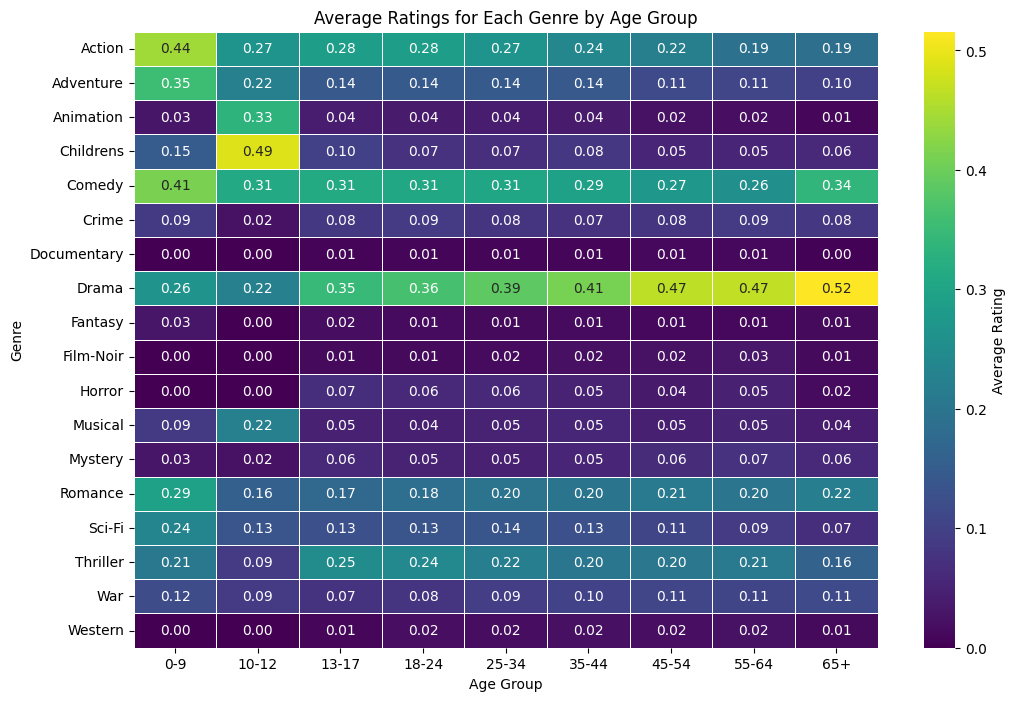

In [ ]:
# convert 'age' to age groups
# define age group bins
age_bins = [0, 10, 13, 18, 25, 35, 45, 55, 65, 100]
# labels for age groups
age_labels = ['0-9', '10-12', '13-17', '18-24', '25-34', '35-44', '45-54', '55-64', '65+']
df_eda['age_group'] = pd.cut(df_eda['age'], bins=age_bins, labels=age_labels, right=False)

count_by_age_group = df_eda.groupby('age_group')[genres].size()
print(count_by_age_group)

# calculate average ratings for each genre within each age group
average_ratings_by_age = df_eda.groupby('age_group')[genres].mean()

# plot a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(average_ratings_by_age.T, cmap='viridis', annot=True, fmt=".2f", linewidths=.5, cbar_kws={'label': 'Average Rating'})
plt.title('Average Ratings for Each Genre by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Genre')
plt.show()


5. Occupation distribution

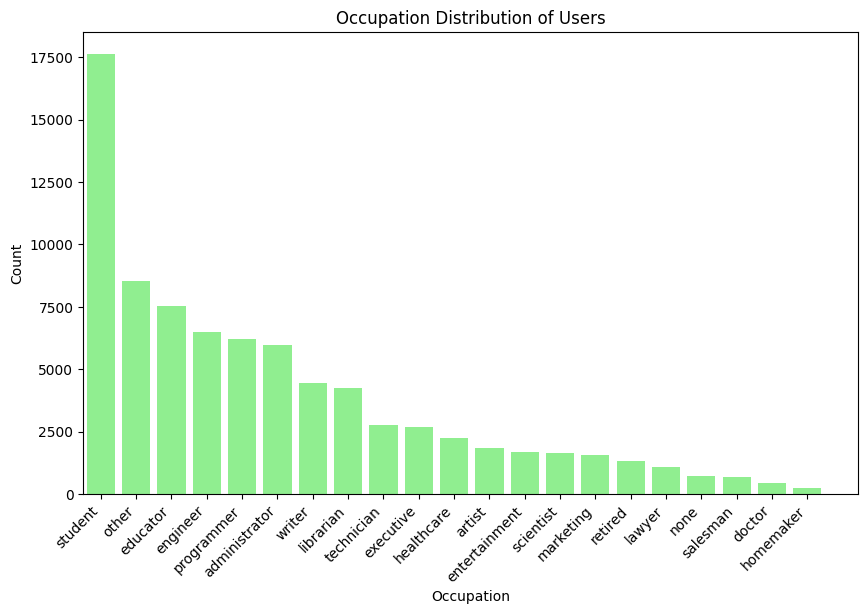

In [ ]:
occupation_counts = df_eda['occupation'].value_counts()
plt.figure(figsize=(10, 6))
plt.bar(occupation_counts.index, occupation_counts.values, color='lightgreen')
plt.title('Occupation Distribution of Users')
plt.xlabel('Occupation')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.xlim(left=-0.5)
plt.show()

6. Analyzing Film Genres and Plotting Number of Films by Number of Genres




Total Number of Films Related to 2+ Genres: 56018
('Action', 'Adventure'): 8272
('Action', 'Thriller'): 8062
('Drama', 'Romance'): 6523
('Action', 'Sci-Fi'): 6402
('Comedy', 'Romance'): 6030
('Drama', 'Thriller'): 4369
('Drama', 'War'): 4137
('Adventure', 'Sci-Fi'): 4129
('Action', 'Romance'): 3724
('Action', 'War'): 3642


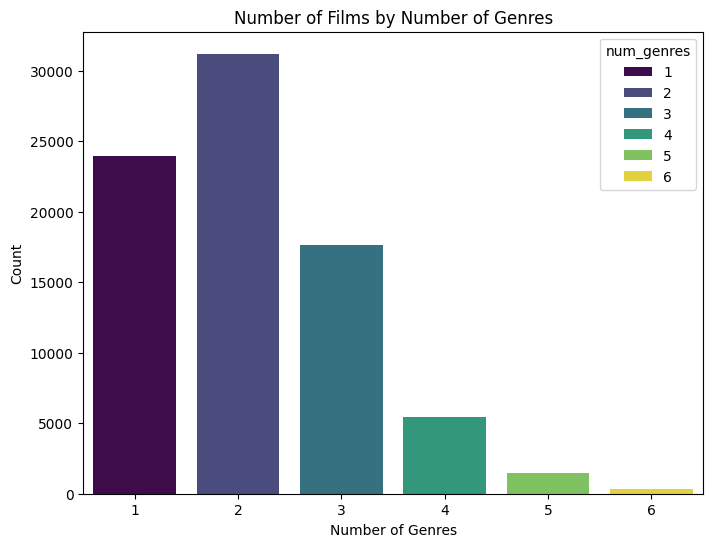

In [ ]:
# count the number of films related to 2+ genres
df_eda_2plus_genres = df_eda[df_eda[genres].sum(axis=1) >= 2]
total_2plus_genres = len(df_eda_2plus_genres)
df_eda_2plus_genres = df_eda[df_eda[genres].sum(axis=1) >= 2]

# extract genre combinations
genre_combinations = []
for index, row in df_eda_2plus_genres.iterrows():
    selected_genres = [genre for genre in genres if row[genre] == 1]
    combinations_of_selected_genres = list(combinations(selected_genres, 2))
    genre_combinations.extend(combinations_of_selected_genres)

# count the occurrences of each genre combination
genre_combination_counts = Counter(genre_combinations)
top_genre_combinations = genre_combination_counts.most_common(10)

print("Total Number of Films Related to 2+ Genres:", total_2plus_genres)
for genre_combination, count in top_genre_combinations:
    print(f"{genre_combination}: {count}")

# total number of genres for each film
df_eda['num_genres'] = df_eda[genres].sum(axis=1)
df_eda_non_zero = df_eda[df_eda['num_genres'] > 0]

# plot the number of films based on the number of genres
plt.figure(figsize=(8, 6))
sns.countplot(x='num_genres', hue='num_genres', data=df_eda_non_zero, palette='viridis')
plt.title('Number of Films by Number of Genres')
plt.xlabel('Number of Genres')
plt.ylabel('Count')
plt.show()

7. Time-based analysis

Total per year:
1997    42358
1998    37605
Name: year, dtype: int64


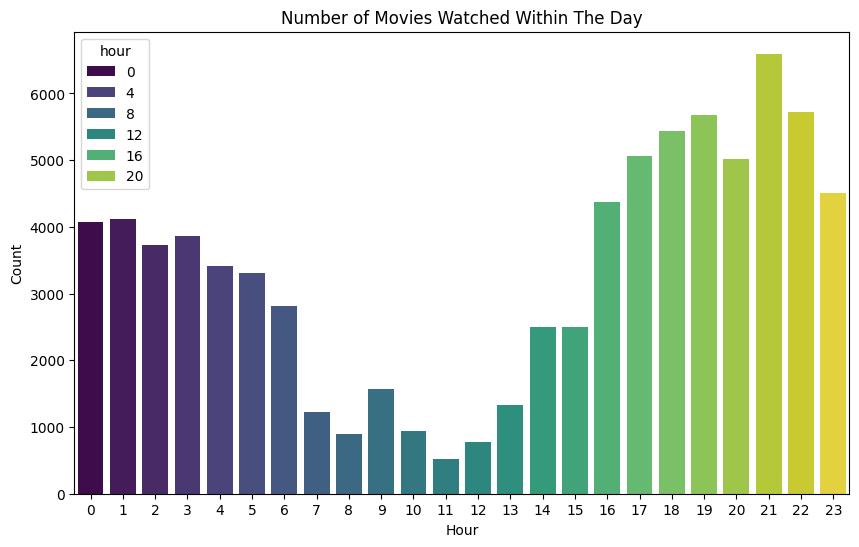

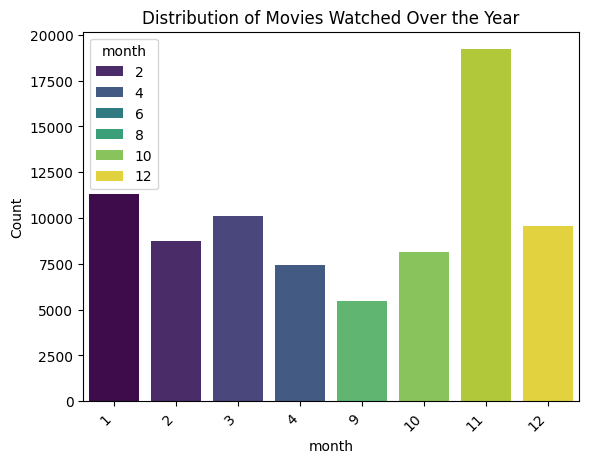

In [ ]:
total_per_year = df_eda['year'].value_counts().sort_index()
print('Total per year:')
print(total_per_year)

# distribution of total per hour
plt.figure(figsize=(10, 6))
sns.countplot(x='hour', hue='hour', data=df_eda, palette='viridis')
plt.title('Number of Movies Watched Within The Day')
plt.xlabel('Hour')
plt.ylabel('Count')
plt.show()


# distribution of total per months over the years
months = df_eda['month']
sns.countplot(x='month',hue='month', data=df_eda, palette='viridis')
plt.title('')
plt.title('Distribution of Movies Watched Over the Year')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

Remove unused columns

In [ ]:
df_eda = df_eda.drop('IMDb_URL', axis=1)
df_eda = df_eda.drop('timestamp', axis=1)
df_eda = df_eda.drop('unknown', axis=1)
df_eda = df_eda.drop('zip_code', axis=1)

# assuming 'release_date' is in the format 'DD-MMM-YY'
df_eda['release_year'] = pd.to_datetime(df_eda['release_date'].str[:3] + df_eda['release_date'].str[-2:], format='%d-%y').dt.strftime('%Y')
print(df_eda)

          Id  user_id  movie_id  rating  hour  day  month  year  age gender  \
0          0      196       242       3    15    4     12  1997   49      M   
1          1      305       242       5     4    1      2  1998   23      M   
2          2        6       242       4     0   28     12  1997   42      M   
3          3      234       242       4    21   27      3  1998   60      M   
4          4      249       242       5     5   15     11  1997   25      M   
...      ...      ...       ...     ...   ...  ...    ...   ...  ...    ...   
79958  79958      851      1675       3     1    8      1  1998   18      M   
79959  79959      863      1678       1    16    7      3  1998   17      M   
79960  79960      863      1680       2    16    7      3  1998   17      M   
79961  79961      896      1681       3     1   11      2  1998   28      M   
79962  79962      916      1682       3    23   29     11  1997   27      M   

       ... Romance Sci-Fi Thriller  War  Western   

Extracting features from imdb

In [ ]:
# retrieve movie information
def fetch_movie_info(title):
    try:
        movies = ia.search_movie(title)
        movie = ia.get_movie(movies[0].getID())
        movie_info = {
            'movie_title': title,
            'year': movie.get('year'),
            'rating': movie.get('rating'),
            'votes': movie.get('votes'),
            'genres': movie.get('genres'),
            'directors': [director.get('name') for director in movie.get('directors')],
            'actor_1': movie.get('cast')[0].get('name') if movie.get('cast') else None,
            'actor_2': movie.get('cast')[1].get('name') if len(movie.get('cast')) > 1 else None,
            'actor_3': movie.get('cast')[2].get('name') if len(movie.get('cast')) > 2 else None,
            'plot': movie.get('plot')[0] if movie.get('plot') else None,
            'runtimes': movie.get('runtimes')[0] if movie.get('runtimes') else None,
            'color_info': movie.get('color info'),
            'countries': movie.get('countries')
        }
        print(title)
        return movie_info

    except Exception as e:
        print(f"Error retrieving information for {title}: {e}")
        return None

# create an instance of the IMDb class
ia = IMDb()

# movie_names = ['Shichinin no samurai']

distinct_movie_titles = df_eda['movie_title'].unique()

# Use ThreadPoolExecutor for parallel processing
with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
    # eetrieve movie information in parallel
    movie_info_list = list(executor.map(fetch_movie_info, distinct_movie_titles))

# write movie data to csv
df_movies = pd.DataFrame(movie_info_list)
df_movies.to_csv('movie_info_final.csv', index=False)


In [ ]:
# explore the movie data
print("Missing values:")
print(df_movies.isnull().sum())

# explore unique genres, handling NaN values
unique_genres = set(genre for genres_list in df_movies['genres'].dropna() for genre in eval(genres_list))
print("Unique Genres:", unique_genres)


# display distinct values for 'color_info' and 'countries' columns

distinct_color_info = df_movies['color_info'].dropna().unique()
distinct_countries = set(genre for genres_list in df_movies['countries'].dropna() for genre in eval(genres_list))

print("Distinct Color Info:", distinct_color_info)
print("Distinct Countries:", distinct_countries)



Missing values:
movie_title     0
year            0
rating          8
votes           8
genres          1
directors       0
actor_1         0
actor_2         7
actor_3        21
plot            9
runtimes        8
color_info      4
countries       5
country         5
genre_1         1
dtype: int64
Unique Genres: {'Film-Noir', 'Romance', 'Sci-Fi', 'Mystery', 'Short', 'Musical', 'Horror', 'Sport', 'Family', 'Adventure', 'Fantasy', 'History', 'Western', 'Comedy', 'Animation', 'Music', 'Talk-Show', 'Drama', 'Action', 'Crime', 'War', 'Biography', 'Documentary', 'Thriller', 'News'}
Distinct Color Info: ["['Color']" "['Color::(Metrocolor)']" "['Color::(Eastmancolor)']"
 "['Color::(Technicolor)']" "['Black and White']" "['Color::(4K)']"
 "['Color::(DeLuxe)']" "['Black and White::(Sepiatone)']"
 "['Color::(Rankcolor)']" "['Color::(DuArt)']" "['Color::(Alphacine)']"
 "['Color::(FotoKem)']" "['Black and White::(4K)']"
 "['Color::(Eastman Color)']" "['Color::(4K Ultra HD Monitor)']"
 "['Color::(De

In [ ]:
# manipulations with imdb data

# leave just 1 country as a feature
df_movies['country'] = df_movies['countries'].apply(lambda x: eval(x)[0] if pd.notna(x) else None)

# take 1st genre as a feature
df_movies['genre_1'] = df_movies['genres'].apply(lambda x: eval(x)[0] if pd.notna(x) else None)

# leave just 1 director as a feature
df_movies['director_1'] = df_movies['directors'].apply(lambda x: eval(x)[0] if pd.notna(x) else None)

In [ ]:
# runtimes ranges groups
df_movies['runtimes_group'] = pd.cut(df_movies['runtimes'], bins=[0, 60, 120, 180, float('inf')], labels=['<60', '60-120', '120-180', '180+'])

# votes ranges groups
df_movies['votes_group'] = pd.cut(df_movies['votes'], bins=[0, 10000, 50000, 100000, float('inf')], labels=['<10k', '10k-50k', '50k-100k', '100k+'])

# rating ranges groups
df_movies['rating_group'] = pd.cut(df_movies['rating'], bins=[0, 5, 7, 9, 10], labels=['<5', '5to7', '7to9', '9to10'])

# year ranges groups
df_movies['year_group'] = pd.cut(df_movies['year'], bins=[1900, 1950, 1960, 1970, 1980, 1990, 2000], labels=['<1950', '1950-1959', '1960-1969', '1970-1979', '1980-1989','1990+'])

# Extract 'Black and White' or 'Color' from color_info
df_movies['color'] = df_movies['color_info'].apply(lambda x: 'Black and White' if isinstance(x, str) and 'Black and White' in x else 'Color')

# Fill NaN values in the new 'color' column with a default value, if needed
df_movies['color'] = df_movies['color'].fillna('Unknown')

In [ ]:
# drop irelevant columns
df_movies = df_movies.drop(['genres', 'votes','rating', 'votes', 'directors', 'runtimes', 'countries', 'color_info'], axis=1)

In [ ]:
# sentiment analysis
nltk.download('vader_lexicon')

# Instantiate the sentiment intensity analyzer
sia = SentimentIntensityAnalyzer()

# Handle missing values in the 'plot' column
df_movies['plot'] = df_movies['plot'].fillna('')  # Replace NaN with an empty string

# Apply sentiment analysis to each plot and create a new column for sentiment scores
df_movies['sentiment_score'] = df_movies['plot'].apply(lambda x: sia.polarity_scores(str(x))['compound'])

print(df_movies)

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # remove special characters, stopwords and digits, all to lowercase, tokenize and lemmatize
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    cleaned_text = ' '.join(tokens)

    return cleaned_text

# Preprocess Text Data
df_movies['cleaned_plot'] = df_movies['plot'].apply(preprocess_text)

# Tokenization
tokenized_plots = df_movies['cleaned_plot'].apply(word_tokenize)

# Train Word2Vec Model
model = Word2Vec(sentences=tokenized_plots, vector_size=100, window=5, min_count=1, workers=4)

# Word Embedding Retrieval
embedding = model.wv['surprise']

# Similarity Analysis
similar_words = model.wv.most_similar('surprise', topn=5)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# Tokenize the cleaned plot text
tokenized_plots = df_movies['cleaned_plot'].apply(word_tokenize)

# Train Word2Vec Model
model = Word2Vec(sentences=tokenized_plots, vector_size=100, window=5, min_count=1, workers=4)

# Function to calculate the average Word2Vec vector for a list of words
def average_word2vec(tokens, model, num_features):
    feature_vector = np.zeros((num_features,), dtype="float32")
    n_words = 0
    for word in tokens:
        if word in model.wv:
            n_words += 1
            feature_vector = np.add(feature_vector, model.wv[word])

    if n_words > 0:
        feature_vector = np.divide(feature_vector, n_words)

    return feature_vector

# Add a new column with Word2Vec vectors
num_features = 100  # Adjust this based on your Word2Vec model size
df_movies['word2vec_vector'] = tokenized_plots.apply(lambda x: average_word2vec(x, model, num_features))


In [ ]:
merged_final_df = pd.merge(df_eda, df_movies, on='movie_title', how='inner')

# drop irelevant columns
merged_final_df = merged_final_df.drop(['genres', 'votes','rating_y', 'votes', 'directors', 'runtimes', 'countries', 'color_info', 'plot', 'cleaned_plot', 'word2vec_vector'], axis=1)
# merged_final_df = merged_final_df.drop('word2vec_vector')
print(merged_final_df)

          Id  user_id  movie_id  rating_x  hour  day  month  year_x  age  \
0          0      196       242         3    15    4     12    1997   49   
1          1      305       242         5     4    1      2    1998   23   
2          2        6       242         4     0   28     12    1997   42   
3          3      234       242         4    21   27      3    1998   60   
4          4      249       242         5     5   15     11    1997   25   
...      ...      ...       ...       ...   ...  ...    ...     ...  ...   
79281  79957      851      1676         2    18    1     10    1997   18   
79282  79958      851      1675         3     1    8      1    1998   18   
79283  79959      863      1678         1    16    7      3    1998   17   
79284  79961      896      1681         3     1   11      2    1998   28   
79285  79962      916      1682         3    23   29     11    1997   27   

      gender  ...            actor_3        country      genre_1  \
0          M  ...  

**Word2Vec**


In [ ]:
# Assume you have a target variable 'rating' in your DataFrame
X = np.vstack(merged_final_df['word2vec_vector'])
y = merged_final_df['rating_x']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Regressor (or any other regression model)
regressor = RandomForestRegressor()
regressor.fit(X_train, y_train)

# Make predictions on the test set
predictions = regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 1.06459824384902


In [ ]:
df_train = pd.read_csv("train_features.csv", encoding='latin1')
df_test = pd.read_csv("test_df_final_25.csv", encoding='latin1')

In [ ]:
df_train['holiday'] = df_train.apply(
    lambda row: holidays.UnitedStates().get(datetime.date(row['year_x'], row['month'], row['day'])) is not None,
    axis=1
).astype(int)

In [ ]:
time_of_day_bins = [0, 6, 12, 18, 24]
time_of_day_labels = ['Night', 'Morning', 'Afternoon', 'Evening']

# Create a new column 'time_of_day'
df_train['time_of_day'] = pd.cut(df_train['hour'], bins=time_of_day_bins, labels=time_of_day_labels, include_lowest=True)
print(df_train)

In [ ]:
df_train['is_weekend'] = df_train.apply(
    lambda row: 1 if pd.to_datetime(f"{row['year_x']}-{row['month']}-{row['day']}").weekday() >= 5 else 0,
    axis=1
).astype(int)

print(df_train[['day', 'month', 'year_x', 'is_weekend']])

In [ ]:
# Define a function to map months to seasons
def get_season(month):
    if 3 <= month <= 5:
        return 'spring'
    elif 6 <= month <= 8:
        return 'summer'
    elif 9 <= month <= 11:
        return 'autumn'
    else:
        return 'winter'

# Create a new column 'season' based on 'month'
df_train['season'] = df_train['month'].apply(get_season)

# Check the unique values in the new 'season' column
print(df_train['season'].unique())

In [ ]:
default_values = {
    'release_date': '1997',
    'year_y': 1998,
    'actor_1': 'none',
    'actor_2': 'none',
    'actor_3': 'none',
    'year_group': '1990+',
    'country': 'United States',
    'genre_1': 'Drama',
    'runtimes_group': '60-120',
    'votes_group': '10k-50k',
    'rating_group': '5to7'
}
df_test.fillna(default_values, inplace=True)

In [ ]:
df_train['industry'] = df_train['occupation'].map({
    'writer': 'Arts',
    'programmer': 'Technology',
    'executive': 'Business',
    'retired': 'Non-working',
    'student': 'Non-working',
    'educator': 'Education',
    'entertainment': 'Arts',
    'technician': 'Technology',
    'marketing': 'Business',
    'scientist': 'Science',
    'artist': 'Arts',
    'administrator': 'Business',
    'engineer': 'Technology',
    'other': 'Other',
    'lawyer': 'Legal',
    'homemaker': 'Non-working',
    'librarian': 'Education',
    'healthcare': 'Healthcare',
    'none': 'Non-working',
    'salesman': 'Business',
    'doctor': 'Healthcare'
})


# Education Level
df_train['education_level'] = df_train['occupation'].map({
    'writer': 'Bachelor',
    'programmer': 'Master',
    'executive': 'Master',
    'retired': 'NA',
    'student': 'Student',
    'educator': 'Bachelor',
    'entertainment': 'Bachelor',
    'technician': 'Associate',
    'marketing': 'Bachelor',
    'scientist': 'Doctorate',
    'artist': 'Bachelor',
    'administrator': 'Bachelor',
    'engineer': 'Master',
    'other': 'NA',
    'lawyer': 'Doctorate',
    'homemaker': 'NA',
    'librarian': 'Master',
    'healthcare': 'Master',
    'none': 'NA',
    'salesman': 'Bachelor',
    'doctor': 'Doctorate'
})

# Work Status
df_train['education'] = df_train['occupation'].map({
    'writer': 'Working Professional',
    'programmer': 'Working Professional',
    'executive': 'Working Professional',
    'retired': 'Non-working',
    'student': 'Non-working',
    'educator': 'Working Professional',
    'entertainment': 'Working Professional',
    'technician': 'Working Professional',
    'marketing': 'Working Professional',
    'scientist': 'Working Professional',
    'artist': 'Working Professional',
    'administrator': 'Working Professional',
    'engineer': 'Working Professional',
    'other': 'Varies',
    'lawyer': 'Working Professional',
    'homemaker': 'Non-working',
    'librarian': 'Working Professional',
    'healthcare': 'Working Professional',
    'none': 'Non-working',
    'salesman': 'Working Professional',
    'doctor': 'Working Professional'
})


In [ ]:
# Assuming merged_final_df is your DataFrame
train_df, val_df = train_test_split(df_train, test_size=0.2, random_state=50)

selected_features = [
    'hour', 'day', 'month', 'year_x', 'gender',
    'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime',
    'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
    'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western',
    'state', 'city', 'age_group', 'year_y',
    'country', 'genre_1', 'director_1', 'runtimes_group', 'votes_group',
    'rating_group', 'year_group', 'color', 'actor_1', 'actor_2', 'actor_3',
    'holiday', 'time_of_day', 'is_weekend', 'season',  'industry'
]

categorical_cols = ['gender','state', 'city', 'age_group', 'country', 'genre_1', 'director_1',
                    'runtimes_group', 'votes_group', 'rating_group', 'year_group', 'color', 'actor_1', 'actor_2', 'actor_3',
    'holiday', 'time_of_day', 'is_weekend', 'season',  'industry']

# Create the transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

# Extracting features and target variable
X_train = train_df[selected_features]
y_train = train_df['rating_x']
X_val = val_df[selected_features]
y_val = val_df['rating_x']

# Fit and transform on training data
X_train_encoded = preprocessor.fit_transform(X_train)

# Transform on validation data
X_val_encoded = preprocessor.transform(X_val)

# Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train_encoded, y_train)
linear_preds = linear_model.predict(X_val_encoded)
linear_mse = mean_squared_error(y_val, linear_preds)
print(f"Linear Regression Mean Squared Error: {linear_mse}")

# Decision Tree Regressor
dt_model = DecisionTreeRegressor(random_state=50)
dt_model.fit(X_train_encoded, y_train)
dt_preds = dt_model.predict(X_val_encoded)
dt_mse = mean_squared_error(y_val, dt_preds)
print(f"Decision Tree Mean Squared Error: {dt_mse}")

# Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(random_state=50)
gb_model.fit(X_train_encoded, y_train)
gb_preds = gb_model.predict(X_val_encoded)
gb_mse = mean_squared_error(y_val, gb_preds)
print(f"Gradient Boosting Mean Squared Error: {gb_mse}")

# Support Vector Machines (SVM) Regressor
svm_model = SVR()
svm_model.fit(X_train_encoded, y_train)
svm_preds = svm_model.predict(X_val_encoded)
svm_mse = mean_squared_error(y_val, svm_preds)
print(f"SVM Mean Squared Error: {svm_mse}")

# Neural Network
nn_model = MLPRegressor(random_state=50)
nn_model.fit(X_train_encoded, y_train)
nn_preds = nn_model.predict(X_val_encoded)
nn_mse = mean_squared_error(y_val, nn_preds)
print(f"Neural Network Mean Squared Error: {nn_mse}")

# Model 2: Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_encoded, y_train)
rf_preds = rf_model.predict(X_val_encoded)
rf_mse = mean_squared_error(y_val, rf_preds)
print(f"Random Forest Mean Squared Error: {rf_mse}")



Linear Regression Mean Squared Error: 0.9299174251846456


KeyboardInterrupt: 

In [ ]:
# Assuming 'day' is the column representing days in your DataFrame
df_train['is_mid_month'] = ((df_train['day'] >= 10) & (df_train['day'] <= 20)).astype(int)
# Assuming 'day' is the column representing days in your DataFrame
df_test['is_mid_month'] = ((df_test['day'] >= 10) & (df_test['day'] <= 20)).astype(int)

In [ ]:
imputer = SimpleImputer(strategy='mean')
train_data, val_data = train_test_split(df_train, test_size=0.2, random_state=50)

selected_features = [
    'user_id', 'month', 'year_x', 'gender', 'occupation', 'age',
    'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime',
    'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
    'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western',
    'state', 'city', 'age_group',  'year_y',
    'country', 'genre_1', 'director_1', 'runtimes_group', 'votes_group',
    'rating_group', 'year_group', 'color', 'actor_1', 'actor_2', 'actor_3',
    'holiday', 'time_of_day', 'is_weekend', 'season'
]

categorical_cols = ['gender', 'occupation', 'state', 'city', 'age_group',
                    'country', 'genre_1', 'director_1', 'runtimes_group',
                    'votes_group', 'rating_group', 'year_group', 'color',
                    'actor_1', 'actor_2', 'actor_3', 'holiday', 'time_of_day', 'season']

# Create the transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

# Extracting features and target variable
X_train = train_data[selected_features]
y_train = train_data['rating_x']
X_val = val_data[selected_features]
y_val = val_data['rating_x']

# Fit and transform on training data
X_train_encoded = preprocessor.fit_transform(X_train)
imputer.fit(X_train_encoded)
X_val_encoded = preprocessor.transform(X_val)
X_val_encoded_imputed = imputer.transform(X_val_encoded)

# Model 2: Random Forest Regressor
rf_model = RandomForestRegressor(random_state=50)
rf_model.fit(X_train_encoded, y_train)

# Predict on validation data
val_predictions = rf_model.predict(X_val_encoded_imputed)

val_mse = mean_squared_error(y_val, val_predictions)
print(f"Validation Set Mean Squared Error (Before Rounding): {val_mse}")

# Display the updated merged_df with the predicted ratings on the validation set
val_results = pd.DataFrame({'movie_id': val_data['movie_id'], 'user_id': val_data['user_id'], 'movie_title': val_data['movie_title'], 'rating': val_predictions})
val_results['rating'] = val_results['rating']

val_mse_rounded = mean_squared_error(y_val, val_results['rating'])
print(f"\nValidation Set Mean Squared Error (After Rounding): {val_mse_rounded}")

print("Validation Set Predictions:")
print(val_results)

# Extracting features for the test set
X_test = df_test[selected_features]

# Transform test data
X_test_encoded = preprocessor.transform(X_test)
X_test_encoded_imputed = imputer.transform(X_test_encoded)

# Predict on the test set
test_predictions = rf_model.predict(X_test_encoded_imputed)

# Add the predicted ratings to the test set
df_test['rating'] = test_predictions

# Display the updated df_test with the predicted ratings
print("\nTest Set Predictions:")
print(df_test[['Id', 'user_id', 'movie_title', 'rating']])

Validation Set Mean Squared Error (Before Rounding): 0.8871950657116632

Validation Set Mean Squared Error (After Rounding): 0.8871950657116632
Validation Set Predictions:
       movie_id  user_id                                      movie_title  \
4129        153      896                      Fish Called Wanda, A (1988)   
24594         2      279                                 GoldenEye (1995)   
69847       809       13                                Rising Sun (1993)   
38915        82      577                             Jurassic Park (1993)   
21255       665      932                                   Alien 3 (1992)   
...         ...      ...                                              ...   
75286       811      666  Thirty-Two Short Films About Glenn Gould (1993)   
32788       475      349                             Trainspotting (1996)   
14502       820      893                                 Space Jam (1996)   
45678       261      319                                  

In [ ]:
# Display the updated df_test with the predicted ratings
print("\nTest Set Predictions:")
print(df_test[['Id', 'movie_id', 'user_id', 'movie_title', 'rating']])
# Display the updated df_test with the predicted ratings
print("\nTest Set Predictions:")
print(df_test[['Id', 'movie_id', 'user_id', 'movie_title', 'rating']])


Test Set Predictions:
          Id  movie_id  user_id                     movie_title  rating
0      79963       242       63                    Kolya (1996)   3.940
1      79964       242      181                    Kolya (1996)   1.940
2      79965       242      201                    Kolya (1996)   3.500
3      79966       242      279                    Kolya (1996)   3.790
4      79967       242      271                    Kolya (1996)   3.710
...      ...       ...      ...                             ...     ...
20032  99995      1662      782              Rough Magic (1995)   2.680
20033  99996      1663      782         Nothing Personal (1995)   2.580
20034  99997      1664      782  8 Heads in a Duffel Bag (1997)   2.594
20035  99998      1677      854            Sweet Nothing (1995)   3.078
20036  99999      1679      863                B. Monkey (1998)   2.710

[20037 rows x 5 columns]


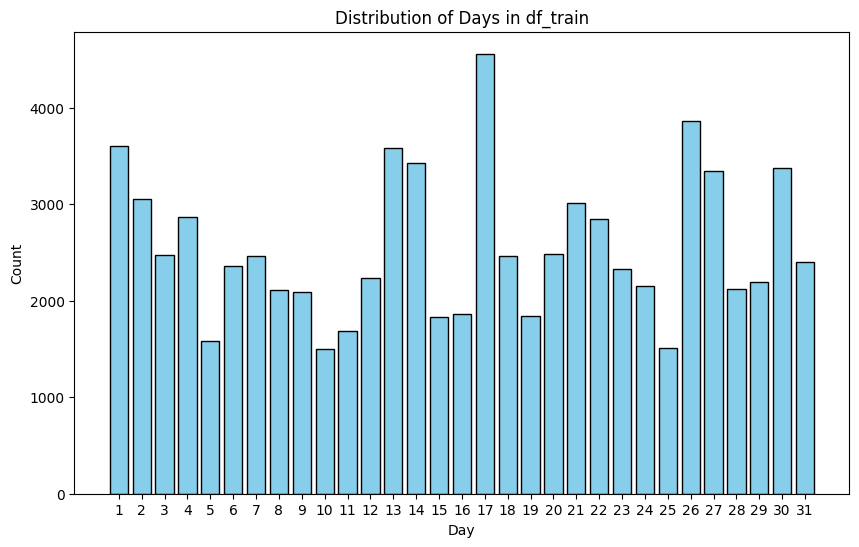

Day Counts in df_train:
1     3603
2     3055
3     2477
4     2872
5     1579
6     2360
7     2463
8     2110
9     2094
10    1505
11    1684
12    2235
13    3585
14    3434
15    1832
16    1867
17    4562
18    2469
19    1847
20    2483
21    3017
22    2846
23    2333
24    2153
25    1513
26    3861
27    3346
28    2127
29    2192
30    3381
31    2401
Name: day, dtype: int64


In [ ]:
day_counts = df_train['day'].value_counts().sort_index()

# Plot the distribution of days
plt.figure(figsize=(10, 6))
plt.bar(day_counts.index, day_counts.values, color='skyblue', edgecolor='black')
plt.title('Distribution of Days in df_train')
plt.xlabel('Day')
plt.ylabel('Count')
plt.xticks(range(1, 32))
plt.show()

# Display the counts
print("Day Counts in df_train:")
print(day_counts)